In [163]:
#### imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import cm
# import scipy as sp
from scipy.fft import fft, ifft, rfft, irfft
from scipy.stats import binned_statistic 
from scipy import integrate
from scipy.interpolate import interp1d

from scipy.optimize import curve_fit
from numpy.polynomial.hermite import hermgauss

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline


plt.rcParams['figure.figsize'] = (8, 4)   
plt.rcParams['font.size'] = 18         
plt.rcParams['axes.titlesize'] = 25     
plt.rcParams['legend.fontsize'] = 22 
plt.rcParams['savefig.dpi'] = 200       
plt.rcParams['axes.labelsize'] = 25

min_slice = 65000
max_slice = 67000

target_redshift = 4.4
safe_z = str(target_redshift).replace('.', '-')

##############################################

# PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
# data = np.loadtxt(PG_file_path)

# # Split into k and P(k)
# k_array = data[:, 0]
# power_array = data[:, 1]


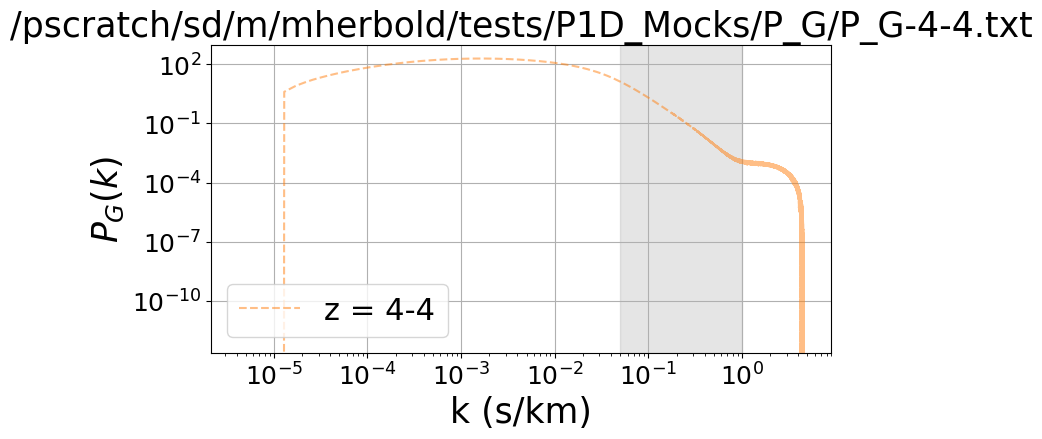

In [164]:
# PG_file_path = '/pscratch/sd/m/mherbold/tests/P1D_Mocks/Backup/P_G-3-0.txt'
# safe_z = '2-8'

PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
data = np.loadtxt(PG_file_path)

# Split into k and P(k)
k_array = data[:, 0]
power_array = data[:, 1]

# k_nyquist = np.pi / dv # check Nyquist Frequency
# plt.axvline(k_nyquist, color='r', linestyle='--', label='k_nyq')
plt.loglog(k_array, power_array, label=f'z = {safe_z.replace("_", ".")}', color='tab:orange',  ls='--', alpha=0.5)
plt.ylabel(r'$P_{G}(k)$')
plt.xlabel('k (s/km)')
plt.axvspan(0.05, 1.0, alpha=0.2, color='grey')
plt.legend()
plt.grid(True)
plt.title(f'{PG_file_path}')
plt.show()

In [165]:
def lambda_c(z, lambda_0 = lambda_0):
    lambda_c = (1+z)*lambda_0
    return(lambda_c)   
    

def delta_transform_1d(file_k_array, file_power_array, 
                       gaussian_random_field_k, dv):
    """
    Transforms a Gaussian white noise field in k-space to a correlated
    Gaussian field in velocity-space, using an imported power spectrum.

    Parameters:
    - file_k_array: array of k values from the power spectrum file [s/km]
    - file_power_array: array of P(k) values [arbitrary units]
    - gaussian_random_field_k: white noise field in rfft space
    - dv: spacing of the velocity grid [km/s]

    Returns:
    - delta_b_tilde: scaled k-space field
    - delta_b: real-space Gaussian field
    - P_k: interpolated and used power spectrum
    """
    N_rfft = gaussian_random_field_k.shape[0]
    N = 2 * (N_rfft - 1)  # size of real-space grid
    k = np.fft.rfftfreq(N, d=dv) * 2 * np.pi  # k in units of 1/km

    power_interp = interp1d(file_k_array, file_power_array, 
                            kind='linear', bounds_error=False, 
                            fill_value=0.0)
    
    P_k = power_interp(k)
   
    # Sanitize P_k to ensure it's all finite and non-negative
    P_k = np.where((P_k > 0) & np.isfinite(P_k), P_k, 0.0)
    delta_b_tilde = gaussian_random_field_k * np.sqrt(P_k / dv)

    # Inverse rFFT to real-space Gaussian field
    delta_b = np.fft.irfft(delta_b_tilde, n=N) / dv

    return delta_b_tilde, delta_b, P_k


def a2_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.power((1. + zp) / (1.+z0), -nu)


def a_z(zp, nu=nu_fid, z0=PD13_PIVOT_Z):
    return np.sqrt(np.power((1. + zp) / (1.+z0), -nu))


def lognormal_transform(delta_z, sigma2_z):     # note: variance of the field, NOT the oneset by mean flux
    n_z = np.exp( (2 * (delta_z) - (sigma2_z)))
    return(n_z)


def t_of_z(zp, tau0=tau0_fid, tau1=tau1_fid, z0= PD13_PIVOT_Z):
    return tau0 * np.power((1. + zp) / (1.+z0), tau1)


def x_of_z(t_z, n_z):
    return t_z * n_z


def f_of_z(x_z):
    return np.exp(-x_z)


# the following are used for the GHQ mean flux calculation
def prefactor(variance):
    prefactor = 1 / (np.sqrt(variance) * np.sqrt(2 * np.pi))
    return(prefactor)


def xz(z, sigma2, tau0=tau0_fid, tau1=tau1_fid, nu=nu_fid, z0=PD13_PIVOT_Z):
    return t_of_z(z, tau0, tau1, z0) * np.exp(-a2_z(z, nu, z0) * sigma2)


def mean_flux(z, variance, z0=PD13_PIVOT_Z):
    integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))
    integral = integrate.quad(integrand, -np.inf, np.inf)[0]
    value = prefactor(variance) * integral
    return(value)


def turner24_mf(z):
    tau_0 = -2.46e-3
    gamma = 3.62
    return np.exp(tau_0 * (1 + z)**gamma)


def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)


def P_F(delta_f):
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / (delta_f.size * dv)
    return(P_F)


def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # window = (kmodes > 1e-5) & (kmodes < 0.05)  # Window for k_arr
    window = (kmodes > 1e-5) & (kmodes < 0.10)  # Window for k_arr
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[window],
                                                       values=power[window],
                                                       statistic='mean', bins=200)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    k_arr = bin_centers
    
    # Remove invalid points
    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    # Initial guess
    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    # Now safe to call curve_fit
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)

    print(f'measured_power size: {power.size}')
    print(f'delta_f size: {delta_f.size}')


    return bin_centers, statistic, *popt_mock
    

def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


In [166]:
seed = 10       # for repeatability
size = 2**20
dv = 1.0
c = 299792.458  # speed of light in km/s
lambda_0 = 1216 # rest wavelength in Angstroms (for Lyα)
velocity_grid = np.arange(size) - size/2

PD13_PIVOT_K = 0.009  # note: k_0
PD13_PIVOT_Z = 3.0    # note: z0 = 3

# fitting parameters from mean flux           
tau0_fid   = 673.77e-3
tau1_fid   = 5.31008
nu_fid     = 2.16175
sigma2_fid = 1.50381

#########################################



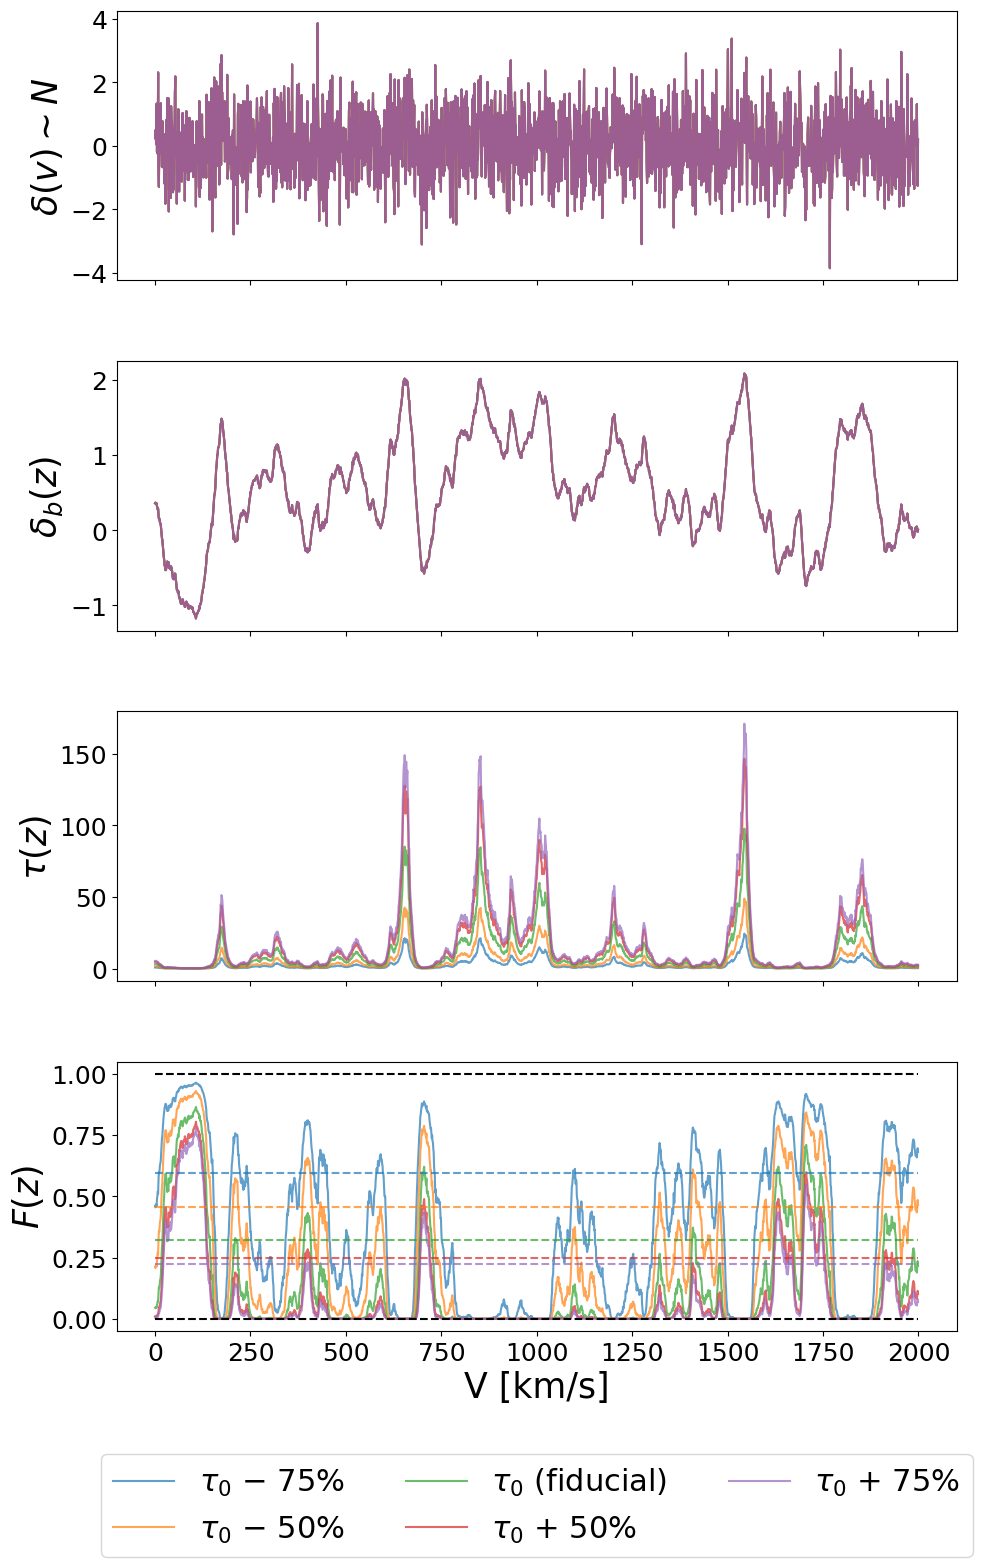

In [167]:
gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv # normalization ?
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)


# factors = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
factors = [0.25, 0.5, 1.0, 1.5, 1.75]  # −75%, −50%, fid, +50%, +75%
tau0_values = [f * tau0_fid for f in factors]

delta_b_z_array = []
tau_array = []
flux_array = []
mean_flux_array = []
labels = []

for tau0 in tau0_values:    
    delta_b_z = delta_b_v * a_z(zp=target_redshift, nu=nu_fid)    
    redshifted_variance_1d = sigma2_fid * a2_z(zp=target_redshift, nu=nu_fid)
    n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
    t_z = t_of_z(zp=target_redshift, tau0=tau0, tau1=tau1_fid)     
    x_z = x_of_z(t_z, n_z)
    f_z = f_of_z(x_z)
    
    delta_b_z_array.append(delta_b_z)
    tau_array.append(x_z)
    flux_array.append(f_z)
    mean_flux_array.append(f_z.mean())
    
    # Labeling
    delta = int(round((tau0 - tau0_fid) / tau0_fid * 100))
    if delta == 0:
        labels.append(r"$\tau_0$ (fiducial)")
    elif delta > 0:
        labels.append(r"$\tau_0$ + {}%".format(delta))
    else:
        labels.append(r"$\tau_0$ − {}%".format(abs(delta)))


# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 15))
# plt.subplots_adjust(hspace=-1, bottom=0.05)  # tighter spacing

plt.subplots_adjust(hspace=-2)  # No vertical space between subplots

for ax in axes[:-1]:
    ax.tick_params(labelbottom=False)  # remove tick labels
    ax.set_xlabel('')                 # remove axis label


# Subplot 1: gaussian field
for label in labels:
    points = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
    ax1.plot(points, label=label, alpha=0.7)
ax1.set_ylabel(r'$\delta(v)\sim N$')

# Subplot 2: δ_b(z)
for d, label in zip(delta_b_z_array, labels):
    ax2.plot(d[min_slice:max_slice], label=label, alpha=0.7)
ax2.set_ylabel(r'$\delta_b(z)$')

# Subplot 3: τ(z)
for t, label in zip(tau_array, labels):
    ax3.plot(t[min_slice:max_slice], label=label, alpha=0.7)
ax3.set_ylabel(r'$\tau(z)$')

# Subplot 4: F(z)
line_objects = []
for f, label in zip(flux_array, labels):
    line, = ax4.plot(f[min_slice:max_slice], label=label, alpha=0.7)
    line_objects.append(line)
for line, mf in zip(line_objects, mean_flux_array):
    color = line.get_color()
    ax4.hlines(y=mf, xmin=0, xmax=len(f[min_slice:max_slice]), color=color, ls='--', alpha=0.7)
ax4.hlines(y=0, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.hlines(y=1, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.set_xlabel('V [km/s]')
ax4.set_ylabel(r'$F(z)$')

# Add legend outside plot
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

fig.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.3, bottom=0.12)  # Leave space for legend
plt.show()


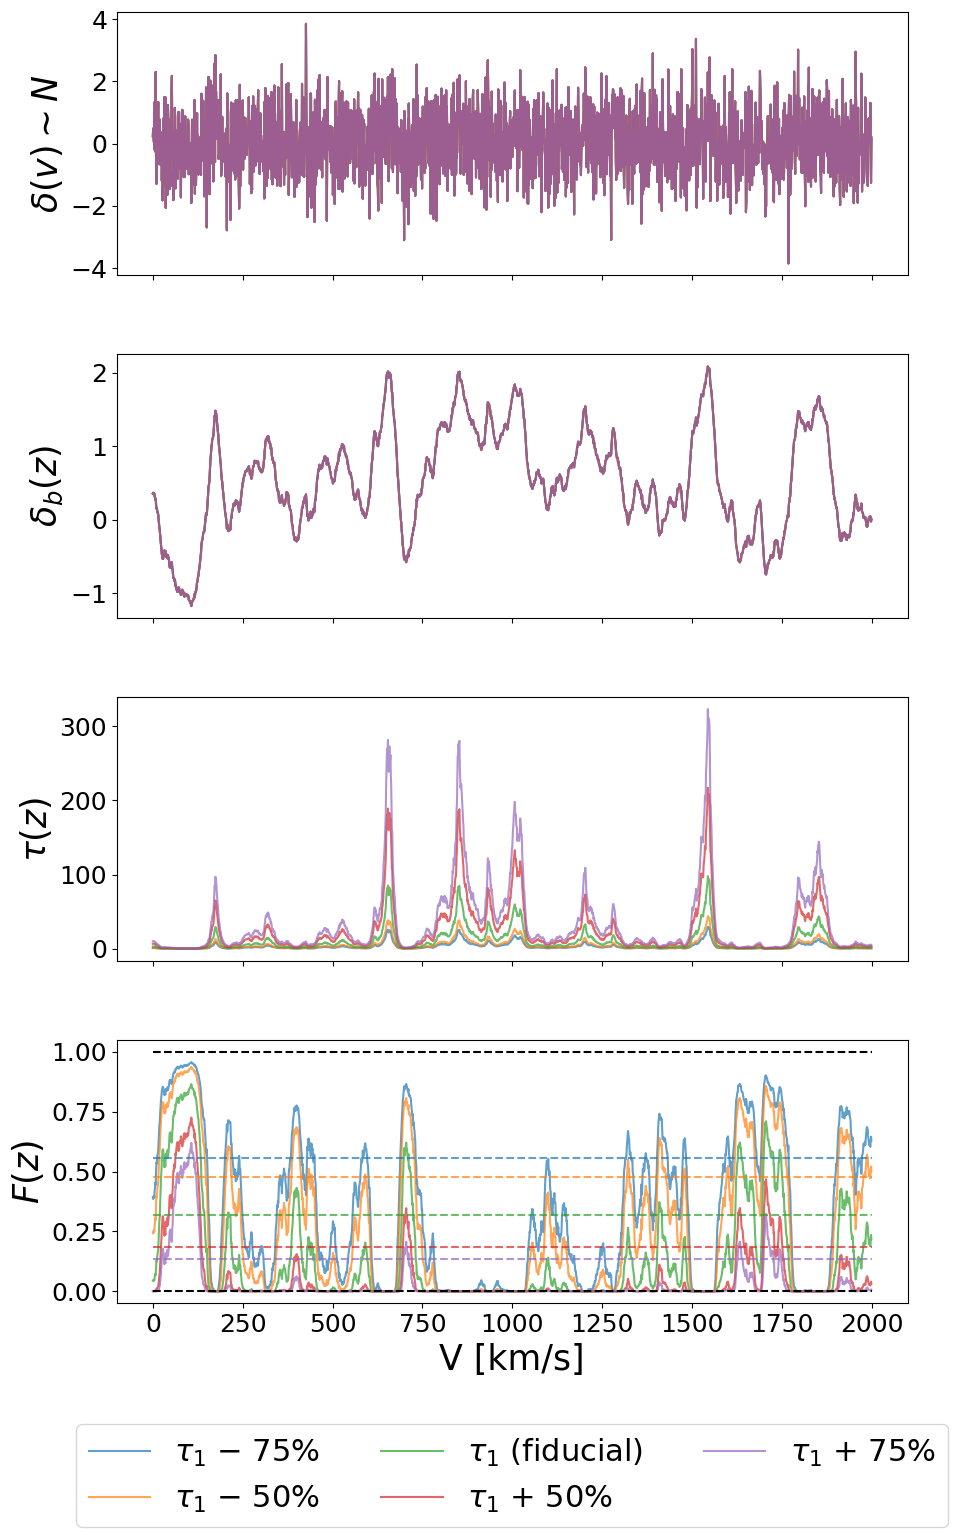

In [168]:
gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv # normalization ?
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)


# factors = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
factors = [0.25, 0.5, 1.0, 1.5, 1.75]  # −75%, −50%, fid, +50%, +75%
tau1_values = [f * tau1_fid for f in factors]

delta_b_z_array = []
tau_array = []
flux_array = []
mean_flux_array = []
labels = []

for tau1 in tau1_values:
    delta_b_z = delta_b_v * a_z(zp=target_redshift, nu=nu_fid)    
    redshifted_variance_1d = sigma2_fid * a2_z(zp=target_redshift, nu=nu_fid)
    n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
    t_z = t_of_z(zp=target_redshift, tau0=tau0_fid, tau1=tau1)     
    x_z = x_of_z(t_z, n_z)
    f_z = f_of_z(x_z)
    
    delta_b_z_array.append(delta_b_z)
    tau_array.append(x_z)
    flux_array.append(f_z)
    mean_flux_array.append(f_z.mean())
    
    # Labeling
    delta = int(round((tau1 - tau1_fid) / tau1_fid * 100))
    if delta == 0:
        labels.append(r"$\tau_1$ (fiducial)")
    elif delta > 0:
        labels.append(r"$\tau_1$ + {}%".format(delta))
    else:
        labels.append(r"$\tau_1$ − {}%".format(abs(delta)))
        

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 15))
plt.subplots_adjust(hspace=0.05, bottom=0.1)

# Subplot 1: gaussian field
for label in labels:
    points = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
    ax1.plot(points, label=label, alpha=0.7)
ax1.set_ylabel(r'$\delta(v)\sim N$')

# Subplot 2: δ_b(z)
for d, label in zip(delta_b_z_array, labels):
    ax2.plot(d[min_slice:max_slice], label=label, alpha=0.7)
ax2.set_ylabel(r'$\delta_b(z)$')

# Subplot 3: τ(z)
for t, label in zip(tau_array, labels):
    ax3.plot(t[min_slice:max_slice], label=label, alpha=0.7)
ax3.set_ylabel(r'$\tau(z)$')

# Subplot 4: F(z)
line_objects = []
for f, label in zip(flux_array, labels):
    line, = ax4.plot(f[min_slice:max_slice], label=label, alpha=0.7)
    line_objects.append(line)
for line, mf in zip(line_objects, mean_flux_array):
    color = line.get_color()
    ax4.hlines(y=mf, xmin=0, xmax=len(f[min_slice:max_slice]), color=color, ls='--', alpha=0.7)
ax4.hlines(y=0, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.hlines(y=1, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.set_xlabel('V [km/s]')
ax4.set_ylabel(r'$F(z)$')

# Add legend outside plot
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

fig.tight_layout()
plt.subplots_adjust(hspace=0.3, bottom=0.12)  # Leave space for legend
plt.show()




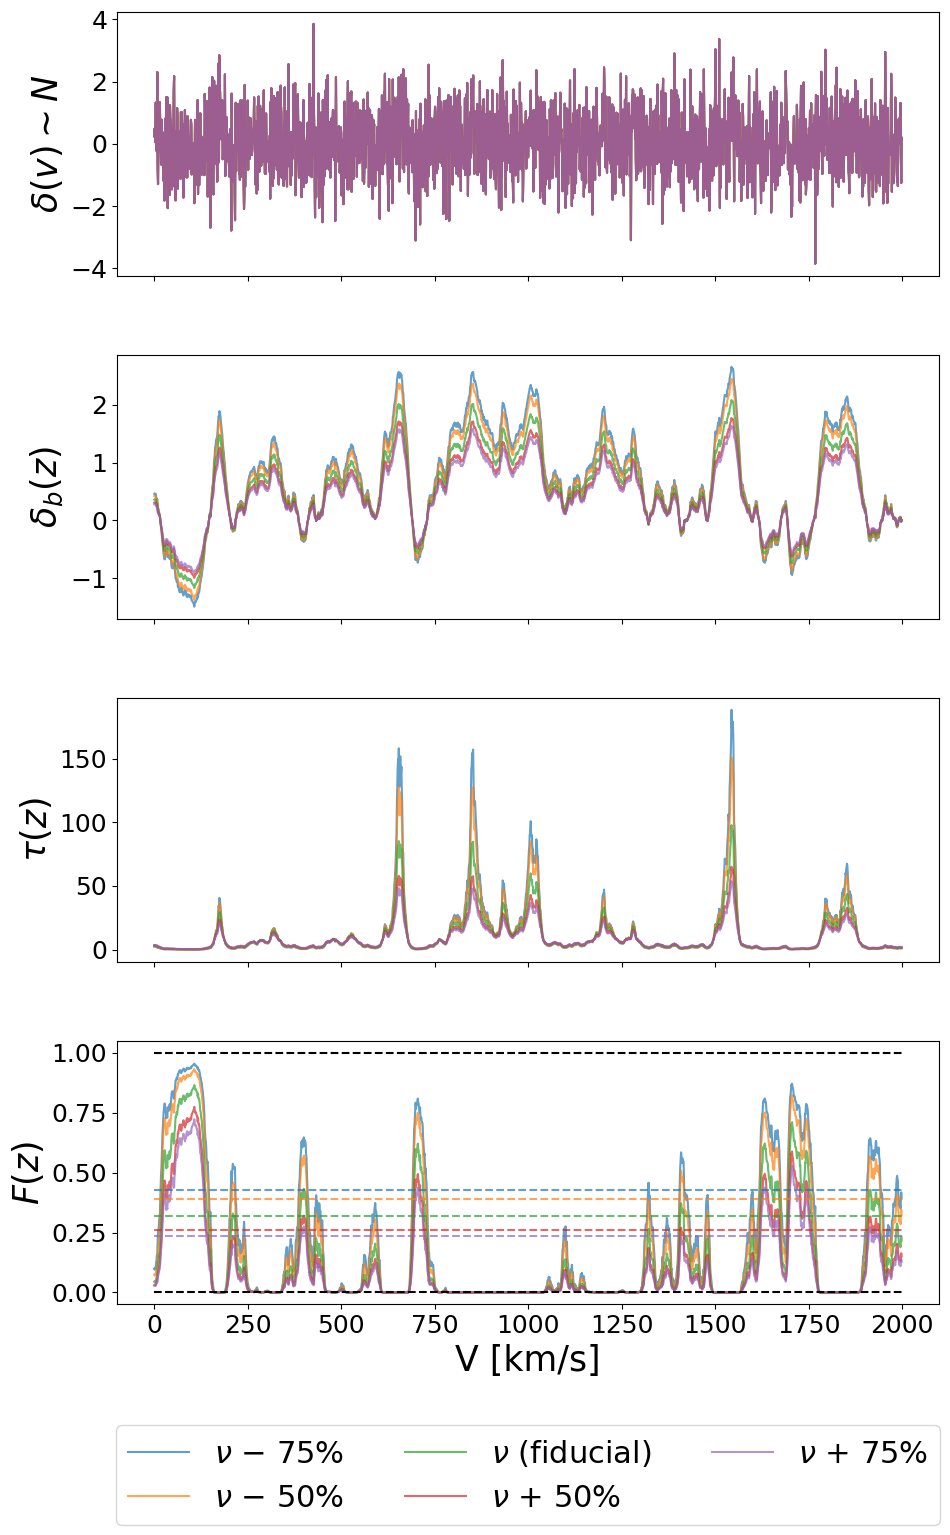

In [172]:
gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv # normalization ?
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)


# factors = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
factors = [0.25, 0.5, 1.0, 1.5, 1.75]  # −75%, −50%, fid, +50%, +75%
nu_values = [f * nu_fid for f in factors]

delta_b_z_array = []
tau_array = []
flux_array = []
mean_flux_array = []
labels = []

for nu in nu_values:
    delta_b_z = delta_b_v * a_z(zp=target_redshift, nu=nu)    
    redshifted_variance_1d = sigma2_fid * a2_z(zp=target_redshift, nu=nu)
    n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
    t_z = t_of_z(zp=target_redshift, tau0=tau0_fid, tau1=tau1_fid)     
    x_z = x_of_z(t_z, n_z)
    f_z = f_of_z(x_z)
    
    delta_b_z_array.append(delta_b_z)
    tau_array.append(x_z)
    flux_array.append(f_z)
    mean_flux_array.append(f_z.mean())
    
    # Labeling
    delta = int(round((nu - nu_fid) / nu_fid * 100))
    if delta == 0:
        labels.append(r"$\nu$ (fiducial)")
    elif delta > 0:
        labels.append(r"$\nu$ + {}%".format(delta))
    else:
        labels.append(r"$\nu$ − {}%".format(abs(delta)))
        

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 15))
plt.subplots_adjust(hspace=0.05, bottom=0.)

# Subplot 1: gaussian field
for label in labels:
    points = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
    ax1.plot(points, label=label, alpha=0.7)
ax1.set_ylabel(r'$\delta(v)\sim N$')

# Subplot 2: δ_b(z)
for d, label in zip(delta_b_z_array, labels):
    ax2.plot(d[min_slice:max_slice], label=label, alpha=0.7)
ax2.set_ylabel(r'$\delta_b(z)$')

# Subplot 3: τ(z)
for t, label in zip(tau_array, labels):
    ax3.plot(t[min_slice:max_slice], label=label, alpha=0.7)
ax3.set_ylabel(r'$\tau(z)$')

# Subplot 4: F(z)
line_objects = []
for f, label in zip(flux_array, labels):
    line, = ax4.plot(f[min_slice:max_slice], label=label, alpha=0.7)
    line_objects.append(line)
for line, mf in zip(line_objects, mean_flux_array):
    color = line.get_color()
    ax4.hlines(y=mf, xmin=0, xmax=len(f[min_slice:max_slice]), color=color, ls='--', alpha=0.7)
ax4.hlines(y=0, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.hlines(y=1, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.set_xlabel('V [km/s]')
ax4.set_ylabel(r'$F(z)$')

# Add legend outside plot
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

fig.tight_layout()
plt.subplots_adjust(hspace=0.3, bottom=0.12)  # Leave space for legend
plt.show()


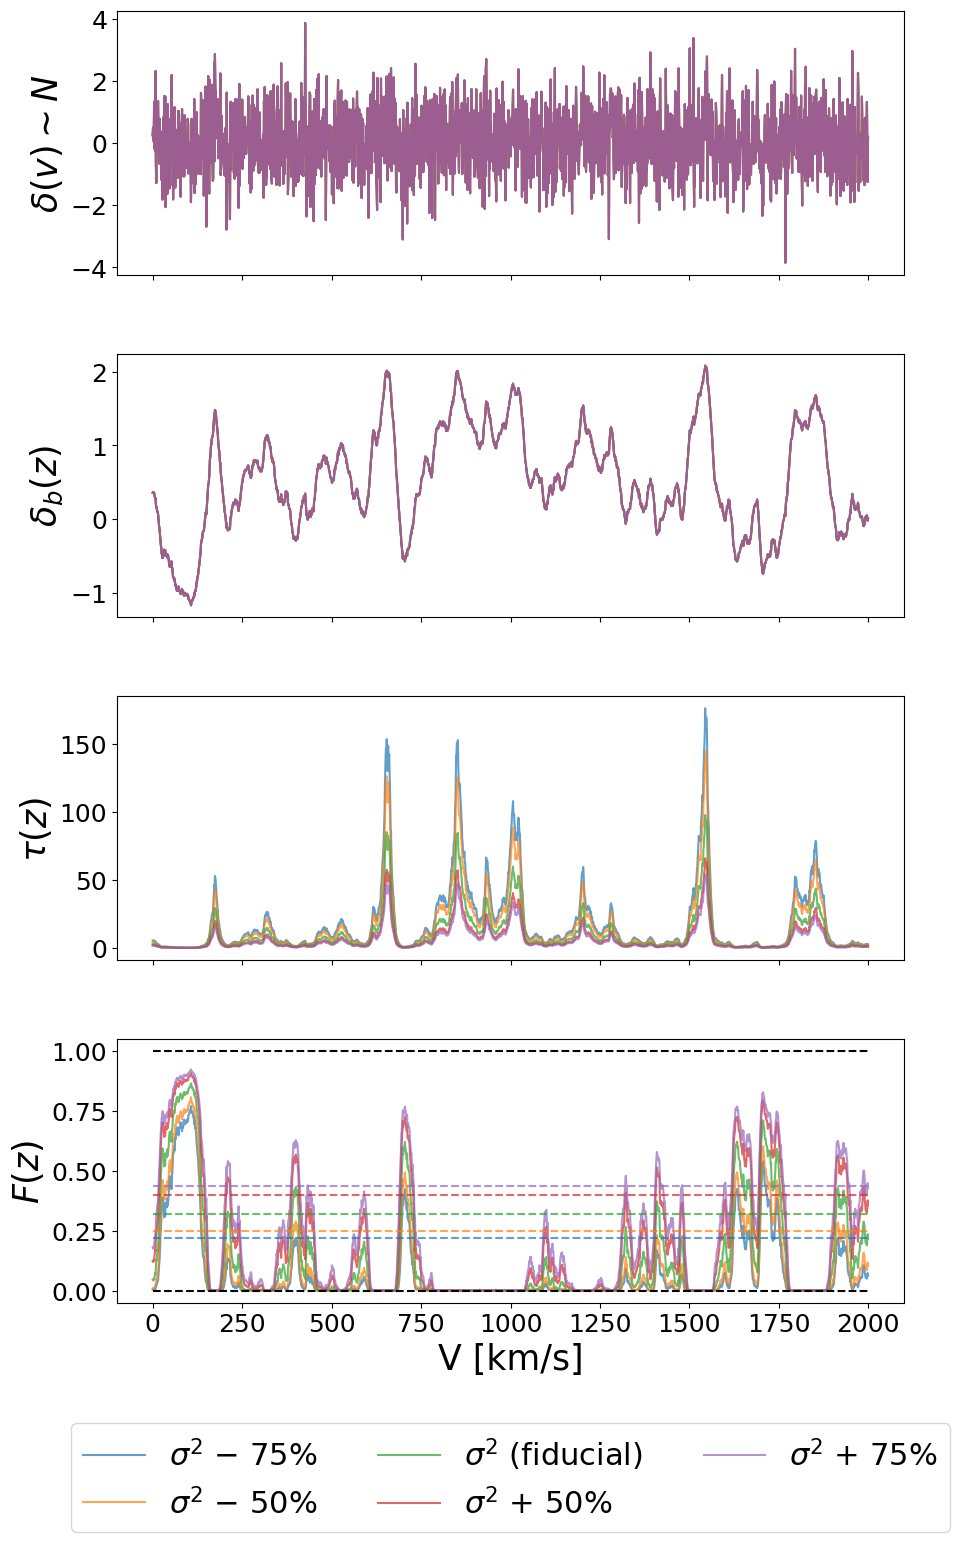

In [176]:
gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv # normalization ?
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)


# factors = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
factors = [0.25, 0.5, 1.0, 1.5, 1.75]  # −75%, −50%, fid, +50%, +75%
sigma2_values = [f * sigma2_fid for f in factors]

delta_b_z_array = []
tau_array = []
flux_array = []
mean_flux_array = []
labels = []

for sigma in sigma2_values:
    delta_b_z = delta_b_v * a_z(zp=target_redshift, nu=nu_fid)    
    redshifted_variance_1d = sigma * a2_z(zp=target_redshift, nu=nu_fid)
    n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
    t_z = t_of_z(zp=target_redshift, tau0=tau0_fid, tau1=tau1_fid)     
    x_z = x_of_z(t_z, n_z)
    f_z = f_of_z(x_z)
    
    delta_b_z_array.append(delta_b_z)
    tau_array.append(x_z)
    flux_array.append(f_z)
    mean_flux_array.append(f_z.mean())
    
    # Labeling
    delta = int(round((sigma - sigma2_fid) / sigma2_fid * 100))
    if delta == 0:
        labels.append(r"$\sigma^2$ (fiducial)")
    elif delta > 0:
        labels.append(r"$\sigma^2$ + {}%".format(delta))
    else:
        labels.append(r"$\sigma^2$ − {}%".format(abs(delta)))
        

# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(10, 15))
plt.subplots_adjust(hspace=0.05, bottom=0.1)

# Subplot 1: gaussian field
for label in labels:
    points = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
    ax1.plot(points, label=label, alpha=0.7)
ax1.set_ylabel(r'$\delta(v)\sim N$')

# Subplot 2: δ_b(z)
for d, label in zip(delta_b_z_array, labels):
    ax2.plot(d[min_slice:max_slice], label=label, alpha=0.7)
ax2.set_ylabel(r'$\delta_b(z)$')

# Subplot 3: τ(z)
for t, label in zip(tau_array, labels):
    ax3.plot(t[min_slice:max_slice], label=label, alpha=0.7)
ax3.set_ylabel(r'$\tau(z)$')

# Subplot 4: F(z)
line_objects = []
for f, label in zip(flux_array, labels):
    line, = ax4.plot(f[min_slice:max_slice], label=label, alpha=0.7)
    line_objects.append(line)
for line, mf in zip(line_objects, mean_flux_array):
    color = line.get_color()
    ax4.hlines(y=mf, xmin=0, xmax=len(f[min_slice:max_slice]), color=color, ls='--', alpha=0.7)
ax4.hlines(y=0, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.hlines(y=1, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.set_xlabel('V [km/s]')
ax4.set_ylabel(r'$F(z)$')

# Add legend outside plot
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

fig.tight_layout()
plt.subplots_adjust(hspace=0.3, bottom=0.12)  # Leave space for legend
plt.show()


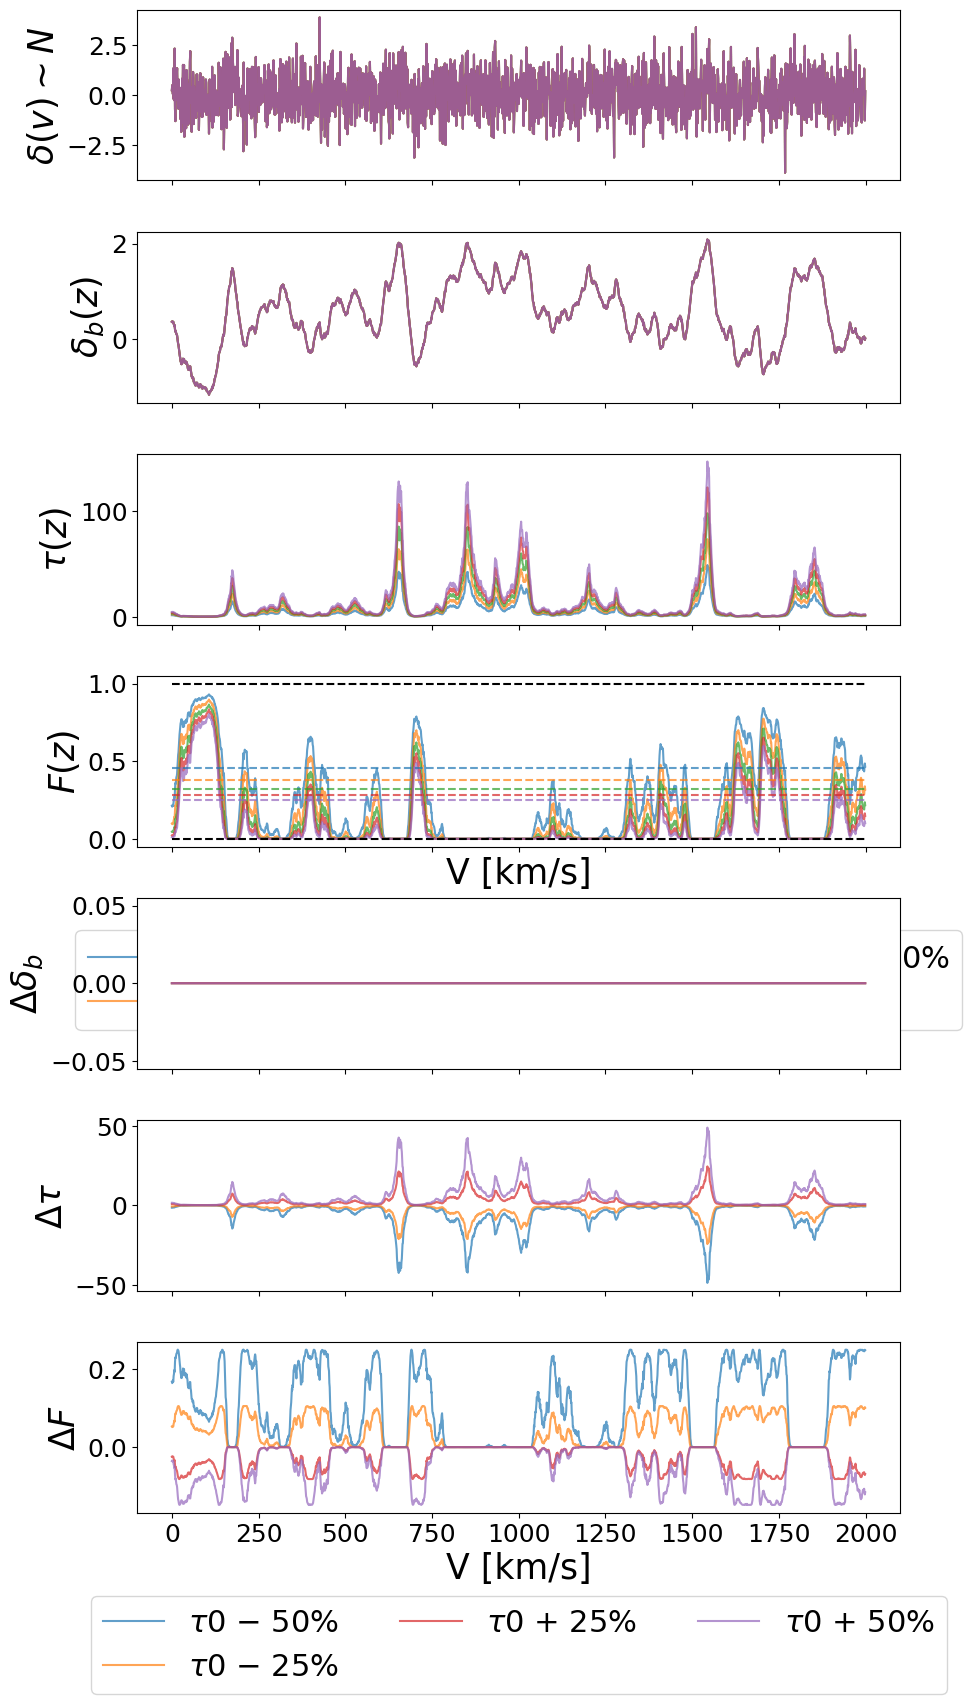

In [181]:
gaussian_random_field = np.random.default_rng(seed).normal(size=size)
gaussian_random_field_k = np.fft.rfft(gaussian_random_field) * dv # normalization ?
kmodes = (np.fft.rfftfreq(n=size, d=dv) * 2 * np.pi) + 1e-12 # note the factor of 2pi
delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
    k_array, power_array, gaussian_random_field_k, dv)


factors = [0.5, 0.75, 1.0, 1.25, 1.5]  # 50%, 75%, 100%, 125%, 150%
# nu_values = [f * nu_fid for f in factors]
# sigma2_values = [f * sigma2_fid for f in factors]
# tau1_values = [f * tau1_fid for f in factors]
tau0_values = [f * tau0_fid for f in factors]


delta_b_z_array = []
tau_array = []
flux_array = []
mean_flux_array = []
labels = []

for tau0 in tau0_values:
    delta_b_z = delta_b_v * a_z(zp=target_redshift, nu=nu_fid)    
    redshifted_variance_1d = sigma2_fid * a2_z(zp=target_redshift, nu=nu_fid)
    n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
    t_z = t_of_z(zp=target_redshift, tau0=tau0, tau1=tau1_fid)     
    x_z = x_of_z(t_z, n_z)
    f_z = f_of_z(x_z)
    
    delta_b_z_array.append(delta_b_z)
    tau_array.append(x_z)
    flux_array.append(f_z)
    mean_flux_array.append(f_z.mean())
    
    # Labeling
    delta = int(round((tau0 - tau0_fid) / tau0_fid * 100))
    if delta == 0:
        labels.append(r"$\tau0$ (fiducial)")
    elif delta > 0:
        labels.append(r"$\tau0$ + {}%".format(delta))
    else:
        labels.append(r"$\tau0$ − {}%".format(abs(delta)))

fid_index = factors.index(1.0)  # index of fiducial value
delta_fid = delta_b_z_array[fid_index]
tau_fid = tau_array[fid_index]
flux_fid = flux_array[fid_index]

delta_residuals = [d - delta_fid for i, d in enumerate(delta_b_z_array) if i != fid_index]
tau_residuals = [t - tau_fid for i, t in enumerate(tau_array) if i != fid_index]
flux_residuals = [f - flux_fid for i, f in enumerate(flux_array) if i != fid_index]
residual_labels = [l for i, l in enumerate(labels) if i != fid_index]
residual_colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][i] for i in range(len(labels)) if i != fid_index]

fig, axes = plt.subplots(nrows=7, sharex=True, figsize=(10, 18))
ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes

# Subplot 1: gaussian field
for label in labels:
    points = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
    ax1.plot(points, label=label, alpha=0.7)
ax1.set_ylabel(r'$\delta(v)\sim N$')

# Subplot 2: δ_b(z)
for d, label in zip(delta_b_z_array, labels):
    ax2.plot(d[min_slice:max_slice], label=label, alpha=0.7)
ax2.set_ylabel(r'$\delta_b(z)$')

# Subplot 3: τ(z)
for t, label in zip(tau_array, labels):
    ax3.plot(t[min_slice:max_slice], label=label, alpha=0.7)
ax3.set_ylabel(r'$\tau(z)$')

# Subplot 4: F(z)
line_objects = []
for f, label in zip(flux_array, labels):
    line, = ax4.plot(f[min_slice:max_slice], label=label, alpha=0.7)
    line_objects.append(line)
for line, mf in zip(line_objects, mean_flux_array):
    color = line.get_color()
    ax4.hlines(y=mf, xmin=0, xmax=len(f[min_slice:max_slice]), color=color, ls='--', alpha=0.7)
ax4.hlines(y=0, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.hlines(y=1, xmin=0, xmax=len(f[min_slice:max_slice]), color='black', ls='--')
ax4.set_xlabel('V [km/s]')
ax4.set_ylabel(r'$F(z)$')

# Add legend outside plot
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

# fig.tight_layout()
# plt.subplots_adjust(hspace=0.3, bottom=0.12)  # Leave space for legend


# ax5: Residual δ_b(z)
for r, c, l in zip(delta_residuals, residual_colors, residual_labels):
    ax5.plot(r[min_slice:max_slice], label=l, color=c, alpha=0.7)
ax5.set_ylabel(r'$\Delta \delta_b$')

# ax6: Residual τ(z)
for r, c, l in zip(tau_residuals, residual_colors, residual_labels):
    ax6.plot(r[min_slice:max_slice], label=l, color=c, alpha=0.7)
ax6.set_ylabel(r'$\Delta \tau$')

# ax7: Residual F(z)
for r, c, l in zip(flux_residuals, residual_colors, residual_labels):
    ax7.plot(r[min_slice:max_slice], label=l, color=c, alpha=0.7)
ax7.set_ylabel(r'$\Delta F$')
ax7.set_xlabel('V [km/s]')

ax7.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3, bottom=0.15)
plt.show()




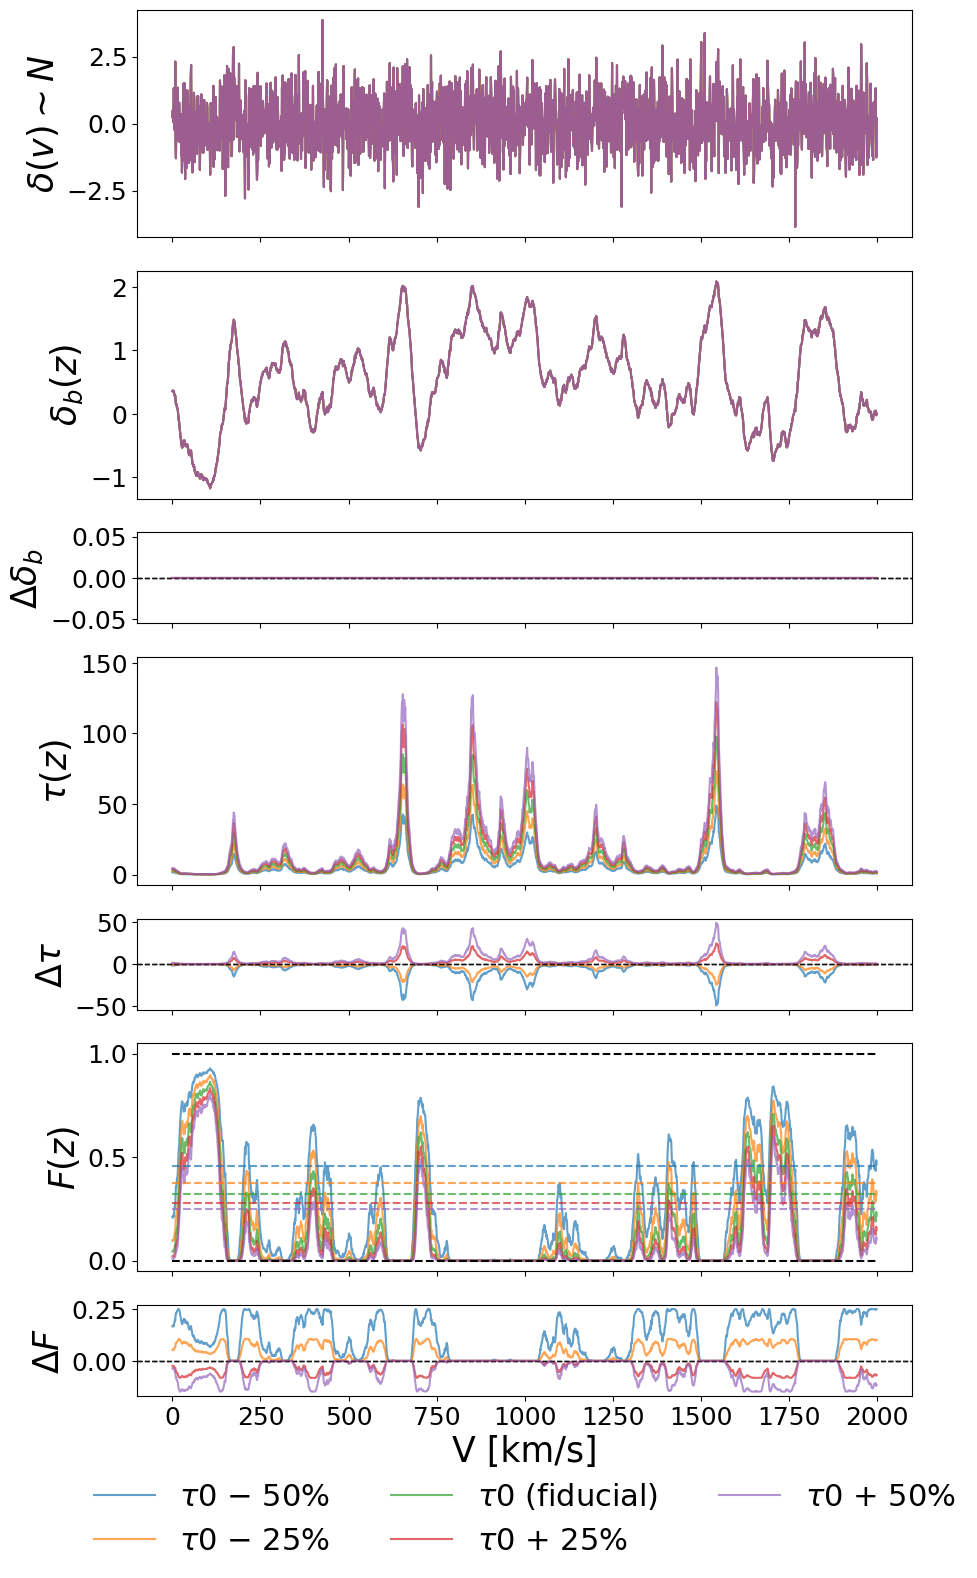

In [182]:
import matplotlib.pyplot as plt

# Define height ratios: [gaussian, δb, δb_res, τ, τ_res, F, F_res]
height_ratios = [1, 1, 0.4, 1, 0.4, 1, 0.4]

fig, axes = plt.subplots(
    nrows=7,
    sharex=True,
    figsize=(10, 18),
    gridspec_kw={"height_ratios": height_ratios},
)

ax1, ax2, ax2r, ax3, ax3r, ax4, ax4r = axes

# 1) Gaussian field
for label in labels:
    pts = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
    ax1.plot(pts, label=label, alpha=0.7)
ax1.set_ylabel(r'$\delta(v)\sim N$')

# 2) δ_b main
for d, label in zip(delta_b_z_array, labels):
    ax2.plot(d[min_slice:max_slice], label=label, alpha=0.7)
ax2.set_ylabel(r'$\delta_b(z)$')

# 3) δ_b residual
for r, c, l in zip(delta_residuals, residual_colors, residual_labels):
    ax2r.plot(r[min_slice:max_slice], label=l, color=c, alpha=0.7)
    ax2r.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax2r.set_ylabel(r'$\Delta \delta_b$')

# 4) τ main
for t, label in zip(tau_array, labels):
    ax3.plot(t[min_slice:max_slice], label=label, alpha=0.7)
ax3.set_ylabel(r'$\tau(z)$')

# 5) τ residual
for r, c, l in zip(tau_residuals, residual_colors, residual_labels):
    ax3r.plot(r[min_slice:max_slice], label=l, color=c, alpha=0.7)
    ax3r.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax3r.set_ylabel(r'$\Delta \tau$')

# 6) F main
line_objs = []
for f, label in zip(flux_array, labels):
    ln, = ax4.plot(f[min_slice:max_slice], label=label, alpha=0.7)
    line_objs.append(ln)
for ln, mf in zip(line_objs, mean_flux_array):
    ax4.hlines(y=mf,
               xmin=0,
               xmax=len(f[min_slice:max_slice]),
               color=ln.get_color(),
               ls='--',
               alpha=0.7)
ax4.hlines([0, 1],
           xmin=0,
           xmax=len(f[min_slice:max_slice]),
           color='black',
           ls='--')
ax4.set_ylabel(r'$F(z)$')

# 7) F residual
for r, c, l in zip(flux_residuals, residual_colors, residual_labels):
    ax4r.plot(r[min_slice:max_slice], label=l, color=c, alpha=0.7)
    ax4r.axhline(y=0, color='black', ls='--', lw=1, alpha=0.5)
ax4r.set_ylabel(r'$\Delta F$')
ax4r.set_xlabel('V [km/s]')

# Legend on the F-main panel (ax4)
ax4.legend(loc='upper center', bbox_to_anchor=(0.5, -0.8), ncol=3, frameon=False)

# Tidy up spacing
# plt.subplots_adjust(hspace=0, bottom=0.5)
# fig.tight_layout()
plt.show()


In [71]:
import numpy as np
import pandas as pd

# Fiducial index and values
fid_index = factors.index(1.0)
delta_fid = delta_b_z_array[fid_index]
tau_fid = tau_array[fid_index]
flux_fid = flux_array[fid_index]
nu_fid_val = nu_values[fid_index]

# Compute RMS differences relative to fiducial
def compute_rms(field_array, fiducial):
    return [np.sqrt(np.mean((arr - fiducial) ** 2)) for arr in field_array]

# Compute for variations (excluding fiducial)
rms_delta = compute_rms([arr for i, arr in enumerate(delta_b_z_array) if i != fid_index], delta_fid)
rms_tau = compute_rms([arr for i, arr in enumerate(tau_array) if i != fid_index], tau_fid)
rms_flux = compute_rms([arr for i, arr in enumerate(flux_array) if i != fid_index], flux_fid)

# Insert fiducial values at the start
nu_all = [nu_fid_val] + [nu for i, nu in enumerate(nu_values) if i != fid_index]
rms_delta_all = [0.0] + rms_delta
rms_tau_all = [0.0] + rms_tau
rms_flux_all = [0.0] + rms_flux

# Create the DataFrame
df = pd.DataFrame({
    'nu': nu_all,
    'RMS(δ_b)': rms_delta_all,
    'RMS(τ)': rms_tau_all,
    'RMS(F)': rms_flux_all
})

# Optional: round and print as markdown
print(df.round(6).to_markdown(index=False))


|      nu |   RMS(δ_b) |   RMS(τ) |   RMS(F) |
|--------:|-----------:|---------:|---------:|
| 2.16175 |          0 |   0      | 0        |
| 1.08088 |          0 |  10.5794 | 0.141117 |
| 1.62131 |          0 |   5.2897 | 0.060104 |
| 2.70219 |          0 |   5.2897 | 0.047421 |
| 3.24262 |          0 |  10.5794 | 0.086306 |


In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.colors as mcolors

# zlist = [4.0]
# factors = [0.5, 0.75, 1.0, 1.25, 1.5]
# nu_values = [f * nu_fid for f in factors]
# line_styles = ['-', '--', ':']  # One per redshift

# # Assign consistent colors to each nu value
# # cmap = cm.get_cmap('rainbow', len(nu_values))
# # color_list = [cmap(i) for i in range(len(nu_values))]

# # Use matplotlib default color cycle (tab:blue, tab:orange, etc.)
# default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_list = default_colors[:len(nu_values)]


# # Store all data: dict[nu][z] = (δb, τ, F, meanF)
# results = {nu: {} for nu in nu_values}

# for z_index, z in enumerate(zlist):
#     target_redshift = z
#     safe_z = str(target_redshift).replace('.', '-')
#     PG_file_path = f'/pscratch/sd/m/mherbold/tests/P1D_Mocks/P_G/P_G-{safe_z}.txt'
#     data = np.loadtxt(PG_file_path)
#     k_array = data[:, 0]
#     power_array = data[:, 1]

#     delta_b_tilde, delta_b_v, P_k_filtered = delta_transform_1d(
#         k_array, power_array, gaussian_random_field_k, dv)

#     for nu in nu_values:
#         delta_b_z = delta_b_v * a_z(zp=target_redshift, nu=nu)
#         redshifted_variance_1d = sigma2_fid * a2_z(zp=target_redshift, nu=nu)
#         n_z = lognormal_transform(delta_b_z, redshifted_variance_1d)
#         t_z = t_of_z(zp=target_redshift, tau0=tau0_fid, tau1=tau1_fid)
#         x_z = x_of_z(t_z, n_z)
#         f_z = f_of_z(x_z)
#         mean_f = f_z.mean()

#         results[nu][z] = (delta_b_z, x_z, f_z, mean_f)

# # === Plotting ===
# fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(8, 10))
# plt.subplots_adjust(hspace=0.05, bottom=0.1)

# for i, (nu, color) in enumerate(zip(nu_values, color_list)):
#     label = r"$\nu$" if nu == nu_fid else (
#         r"$\nu$ + {}%".format(int((nu - nu_fid) / nu_fid * 100))
#         if nu > nu_fid else r"$\nu$ − {}%".format(abs(int((nu - nu_fid) / nu_fid * 100)))
#     )

#     for j, z in enumerate(zlist):
#         ls = line_styles[j]
#         delta_b_z, tau_z, flux_z, mean_flux = results[nu][z]

#         # Gaussian field: repeated same RNG for consistent slice
#         gfield = np.random.default_rng(seed).normal(size=size)[min_slice:max_slice]
#         if i == 0:  # only once per redshift
#             ax1.plot(gfield, color='gray', ls='-', alpha=0.3)

#         ax2.plot(delta_b_z[min_slice:max_slice], color=color, ls=ls, alpha=0.5)
#         ax3.plot(tau_z[min_slice:max_slice], color=color, ls=ls, alpha=0.5)
#         ax4.plot(flux_z[min_slice:max_slice], color=color, ls=ls, alpha=0.5)
#         ax4.hlines(y=mean_flux, xmin=0, xmax=len(flux_z[min_slice:max_slice]),
#                    color=color, ls=ls, alpha=0.5)

# # Axis labels
# ax1.set_ylabel(r'$\delta(v)\sim N$')
# ax2.set_ylabel(r'$\delta_b(z)$')
# ax3.set_ylabel(r'$\tau(z)$')
# ax4.set_ylabel(r'$F(z)$')
# ax4.set_xlabel('V [km/s]')
# ax4.hlines([0, 1], xmin=0, xmax=len(flux_z[min_slice:max_slice]), color='black', ls='--', alpha=0.7)

# # Custom legend (one entry per nu value)
# from matplotlib.lines import Line2D
# legend_elements = [
#     Line2D([0], [0], color=color, lw=2, label=(
#         r"$\nu$" if nu == nu_fid else
#         r"$\nu$ + {}%".format(int((nu - nu_fid) / nu_fid * 100))
#         if nu > nu_fid else r"$\nu$ − {}%".format(abs(int((nu - nu_fid) / nu_fid * 100)))
#     )) for nu, color in zip(nu_values, color_list)
# ]



# # Add legend outside plot
# ax4.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=3)

# fig.tight_layout()
# plt.subplots_adjust(hspace=0.3, bottom=0.12)  # Leave space for legend
# plt.show()


In [ ]:
# # Initialize figure and axis
# fig, ax = plt.subplots()

# # Store plotted line objects to extract colors
# line_objects = []

# # Plot flux curves and store line handles
# for f, label in zip(flux_array, labels):
#     line, = ax.plot(f[min_slice:max_slice], label=label, alpha=0.4)
#     line_objects.append(line)

# # Now plot matching mean flux lines using the same colors
# for line, mf in zip(line_objects, mean_flux_array):
#     color = line.get_color()  # extract color used by the corresponding flux line
#     ax.hlines(y=mf, xmin=0, xmax=5000, color=color, ls='--', alpha=0.7)

# # Decorate plot
# ax.set_xlabel('V [km/s]')
# ax.set_ylabel(f'F(z = {target_redshift})')
# ax.hlines(y=0, xmin=0, xmax=5000, color='black', ls='--')
# ax.hlines(y=1, xmin=0, xmax=5000, color='black', ls='--')
# ax.legend(loc='lower right', ncol=2)
# fig.tight_layout()
# plt.show()


In [92]:
# # Initialize figure and axis
# fig, ax = plt.subplots()

# # Store plotted line objects to extract colors
# line_objects = []

# # Plot flux curves and store line handles
# for f, label in zip(flux_array, labels):
#     line, = ax.plot(f[min_slice:max_slice], label=label, alpha=0.7)
#     line_objects.append(line)

# # Now plot matching mean flux lines using the same colors
# for line, mf in zip(line_objects, mean_flux_array):
#     color = line.get_color()
#     ax.hlines(y=mf, xmin=0, xmax=5000, color=color, ls='--', alpha=0.7)

# # Decorate plot
# ax.set_xlabel('V [km/s]')
# ax.set_ylabel(f'F(z = {target_redshift})')
# ax.hlines(y=0, xmin=0, xmax=5000, color='black', ls='--')
# ax.hlines(y=1, xmin=0, xmax=5000, color='black', ls='--')

# # Move legend outside plot
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=2, frameon=True)

# # Adjust layout to fit everything
# fig.tight_layout()
# plt.subplots_adjust(right=0.75)  # Make space for the legend
# plt.show()


/tmp/ipykernel_1100062/1229288549.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))


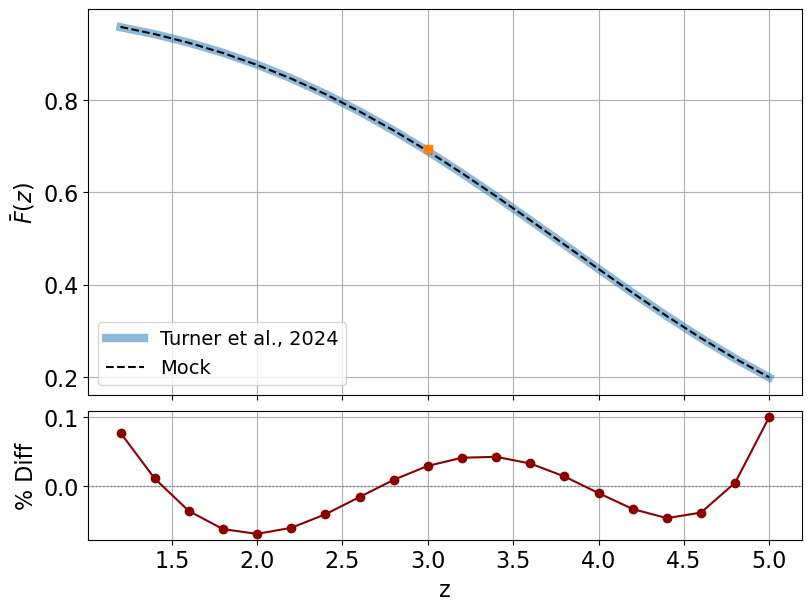

In [163]:
z_list = np.array([1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3.0, 3.2, 3.4, 3.6,
       3.8, 4. , 4.2, 4.4, 4.6, 4.8, 5.0])

flux_list = []
for i in z_list:
    flux_list.append(mean_flux(z=i,variance=variance_1d, z0=3))

# Turner et al. (2024) model
turner_flux = turner24_mf(z_list)

# Calculate percent difference
residuals = 100 * (flux_list - turner_flux) / turner_flux

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6), 
                               gridspec_kw={'height_ratios': [3, 1]}, 
                               constrained_layout=True)

# Top panel: mean flux comparison
ax1.plot(z_list, turner_flux, label='Turner et al., 2024', lw=6, alpha=0.5)
ax1.plot(z_list, flux_list, label='Mock', ls='--', color='black')
ax1.plot(target_redshift, f_z.mean(), 's')
ax1.set_ylabel(r'$\bar F(z)$')
# ax1.set_title('Mean Flux Comparison')
ax1.legend(loc='lower left')
ax1.grid()

# Bottom panel: percent difference
ax2.axhline(0, color='gray', lw=1, ls=':')
ax2.plot(z_list, residuals, marker='o', color='darkred')
ax2.set_xlabel('z')
ax2.set_ylabel('% Diff')
ax2.grid()

plt.show()


In [164]:
def delta_F(z, variance, input_flux, z0=PD13_PIVOT_Z):
    f_bar = mean_flux(z,variance,z0)
    flux = input_flux
    delta_f = (flux - f_bar) / (f_bar)
    return(delta_f)

# def delta_F_k(z, variance, input_flux, z0=PD13_PIVOT_Z):
#     f_bar = mean_flux(z,variance,z0)
#     flux = input_flux
#     delta_f = (flux - f_bar) / (f_bar)
#     delta_f_tilde = np.fft.rfft(delta_f) * dv
#     return(delta_f_tilde)

def P_F(delta_f):
    delta_f_tilde = np.fft.rfft(delta_f) * dv
    P_F = np.abs(delta_f_tilde)**2 / (delta_f.size * dv)
    return(P_F)

In [165]:

test_flux = f_z
delta_f = delta_F(z=target_redshift, variance=redshifted_variance_1d, input_flux=test_flux)
test_power = P_F(delta_f)

N = len(delta_f)

kmodes2 = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi

window = (kmodes2 > 1e-5) & (kmodes2 < 0.05)  # Window for k_arr


/tmp/ipykernel_1100062/1229288549.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))


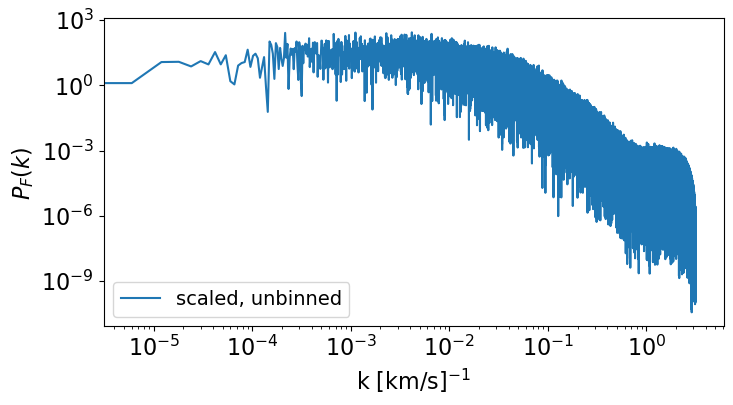

In [166]:
plt.loglog(kmodes2, test_power, label='scaled, unbinned')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel('k [km/s$]^{-1}$')
plt.legend()

statistic shape:  200
bin edges shape:  201
bin number shape: 16687
bin width: 0.000500


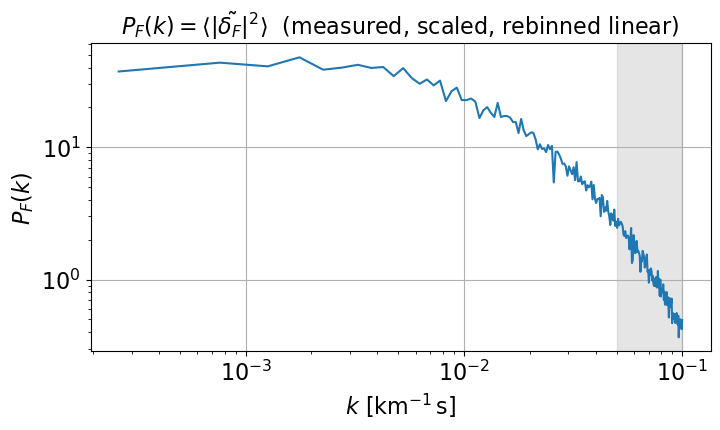

In [167]:
window = (kmodes2 > 1e-5) & (kmodes2 < 0.1)  # Window for k_arr

statistic_test, bin_edges_test, binnumber_test = binned_statistic(x = kmodes2[window], 
                                                                  values = test_power[window], 
                                                                  statistic = 'mean', bins=200)
print("statistic shape:  " + str(statistic_test.shape[0])) # The values of the selected statistic in each bin, mean here
print("bin edges shape:  " + str(bin_edges_test.shape[0])) # Return the bin edges (length(statistic)+1).
print("bin number shape: " + str(binnumber_test.shape[0])) # Indices of the bins (corresponding to bin_edges) 
                                                           # in which each value of x belongs. Same length as values 
    
    
bin_centers = 0.5 * (bin_edges_test[1:] + bin_edges_test[:-1])
plt.loglog(bin_centers, statistic_test)
bin_width = bin_edges_test[1] - bin_edges_test[0]
print(f"bin width: {bin_width:2f}")

# plt.loglog(bin_edges_test[4:], statistic_test[3:])
plt.title(r'$P_F(k) = \langle | \tilde{\delta_F} |^2 \rangle$  (measured, scaled, rebinned linear)')
plt.ylabel(r'$P_F(k)$ ')
plt.xlabel(r'$k\ \left[\mathrm{km}^{-1}\,\mathrm{s}\right]$')
plt.rcParams["figure.figsize"] = (9,5)
plt.axvspan(0.05, 0.1, alpha=0.2, color='grey')
plt.grid(True)

In [168]:
def fit_PD13Lorentz(delta_f, dv, z):
    power = P_F(delta_f)
    N = len(delta_f)
    kmodes = np.fft.rfftfreq(n=N, d=dv) * 2 * np.pi
    # window = (kmodes > 1e-5) & (kmodes < 0.05)  # Window for k_arr
    window = (kmodes > 1e-5) & (kmodes < 0.10)  # Window for k_arr
    statistic, bin_edges, binnumber = binned_statistic(x=kmodes[window],
                                                       values=power[window],
                                                       statistic='mean', bins=200)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    k_arr = bin_centers
    
    # Remove invalid points
    valid = np.isfinite(statistic) & np.isfinite(bin_centers)
    bin_centers = bin_centers[valid]
    statistic = statistic[valid]

    # Initial guess
    p0 = (0.07, -2.5, -0.1, 3.5, 0.3, 700)
    
    # Now safe to call curve_fit
    popt_mock, pcov_mock = curve_fit(
        lambda k, A, n, alpha, B, beta, lmd: evaluatePD13Lorentz(
            (k,z), A, n, alpha, B, beta, lmd),
        bin_centers, statistic, p0=p0, maxfev=20000)

    print(f'measured_power size: {power.size}')
    print(f'delta_f size: {delta_f.size}')


    return bin_centers, statistic, *popt_mock

In [98]:
DESI_EDR_PARAMETERS = (
    7.63089e-02, -2.52054e+00, -1.27968e-01,
    3.67469e+00, 2.85951e-01, 7.33473e+02)

Naim_old_param = (
    0.066, -2.685, -0.22, 3.59, -0.18, 0.53)


def evaluatePD13Lorentz(X, A, n, alpha, B, beta, lmd):
    k, z = X
    q0 = k / PD13_PIVOT_K + 1e-10
    result = (A * np.pi / PD13_PIVOT_K) * np.power(
        q0, 2. + n + alpha * np.log(q0)) / (1. + lmd * k**2)
    if z is not None:
        x0 = (1. + z) / (1. + PD13_PIVOT_Z)
        result *= np.power(q0, beta * np.log(x0)) * np.power(x0, B)
    return result


In [103]:
test_flux = f_z
delta_f = delta_F(z=target_redshift, variance=redshifted_variance_1d, input_flux=test_flux)
test_power = P_F(delta_f)
bin_centers, stat, *popt_mock_param = fit_PD13Lorentz(delta_f, dv, target_redshift)

mock_fit = evaluatePD13Lorentz((bin_centers,target_redshift), *popt_mock_param)
desi_model = evaluatePD13Lorentz((bin_centers,target_redshift), *DESI_EDR_PARAMETERS)
naim_fit = evaluatePD13Lorentz((bin_centers,target_redshift), *Naim_old_param)

# percent_diff = 100 * (mock_fit - desi_model) / desi_model
percent_diff = 100 * (stat - desi_model) / desi_model
percent_diff1 = 100 * (mock_fit - desi_model) / desi_model
percent_diff2 = 100 * (naim_fit - desi_model) / desi_model

measured_power size: 524289
delta_f size: 1048576


/tmp/ipykernel_1100062/1229288549.py:11: RuntimeWarning: overflow encountered in exp
  integrand = lambda x: np.exp((-(x**2) / (2 * variance)) - ((xz(z, variance)) * np.exp(2 * (a_z(z)) * x)))


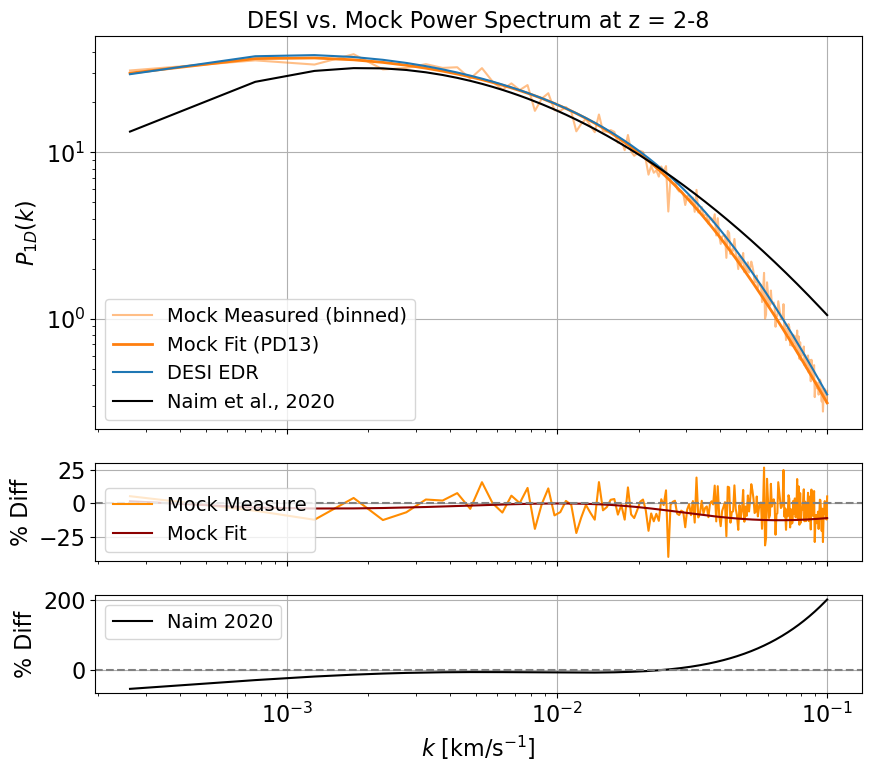

In [105]:

p1d_precision = 1e-1
# w_k = (bin_centers > 1e-5) & (bin_centers < 0.05)  # Window for k_arr
w_k = (bin_centers > 1e-5) & (bin_centers < 0.1)  # Window for k_arr
ptrue = desi_model[w_k].ravel()
e_p1d = p1d_precision * ptrue + 1e-8

# Extract data using index mask (w_k)
temp_k = bin_centers[w_k]
temp_p = desi_model[w_k]
temp_e = np.full_like(temp_k, e_p1d)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [4, 1, 1]})
# Upper plot
ax1.loglog(bin_centers, stat, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[w_k], desi_model[w_k], 
    color='tab:blue', label=r'DESI EDR')
# ax1.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e,
#                  color='tab:blue', alpha=0.5, label=' ± precision')
ax1.loglog(bin_centers[w_k], naim_fit[w_k], 
    color='black', label=r'Naim et al., 2020')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')

# Lower plot (residuals)
ax2.semilogx(bin_centers, percent_diff, color='darkorange', label='Mock Measure')
ax2.semilogx(bin_centers, percent_diff1, color='darkred', label='Mock Fit')
# ax2.semilogx(bin_centers, percent_diff2, color='black', label='Naim 2020')
ax2.axhline(0, ls='--', color='gray')
# ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('% Diff')
ax2.grid(True)
ax2.legend(loc='lower left')

ax3.semilogx(bin_centers, percent_diff2, color='black', label='Naim 2020 fit')
ax3.axhline(0, ls='--', color='gray')
ax3.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax3.set_ylabel('% Diff')
ax3.grid(True)

plt.legend()
plt.tight_layout()
plt.show()


In [41]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# # Upper plot (model comparison)
# # ax1.loglog(bin_centers, statistic_test, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
# ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='This Work', lw=2)
# ax1.loglog(bin_centers[w_k], desi_model[w_k], color='tab:blue', label=r'DESI EDR')
# ax1.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e, color='tab:blue', alpha=0.5, label=' ± precision')
# ax1.loglog(bin_centers[w_k], naim_model[w_k], color='black', label=r'Naim et al., 2020')
# ax1.set_ylabel(r'$P_{1D}(k)$')
# ax1.legend(loc='lower center')
# ax1.grid(True)
# ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z}')

# # Lower plot (improvement between mock_fit and naim_model)
# improvement = percent_diff - percent_diff2  # Calculate the improvement
# # ax2.semilogx(bin_centers, improvement, color='green', label='Improvement (Mock vs Naim)')

# # Fill both positive and negative improvements
# ax2.fill_between(bin_centers, np.abs(improvement), 0, color='green', alpha=0.5, label='Improvement')

# ax2.axhline(0, ls='--', color='gray')
# ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
# ax2.set_ylabel('Improvement [%]')
# ax2.grid(True)

# # Additional annotation for improvement
# max_diff_index = np.argmax(improvement)
# # ax2.annotate(f'Max Improvement', xy=(bin_centers[max_diff_index], improvement[max_diff_index]), 
# #              xytext=(bin_centers[max_diff_index]*1.1, improvement[max_diff_index]*1.2),
# #              arrowprops=dict(facecolor='black', shrink=0.05),
# #              fontsize=9)

# plt.legend(loc='upper center')
# plt.tight_layout()
# plt.show()


#### look at chi2

The chi-squared statistic is a measure of how well a model (or theory) fits a set of observed data. It's calculated by comparing the differences between observed values ($y_i$) and model predictions ($f_i$) while accounting for measurement errors ($\sigma_i$). 

For each data point $i$, the difference between the model and data is squared, and this difference is scaled by the error for that data point to account for varying uncertainty: 

$$\chi^2 = \Sigma \frac{(y_i - f_i)^2}{\sigma_i^2}$$

This gives a sense of how large the residuals are (i.e., the difference between the observed and predicted values), and by squaring them, it prevents canceling out positive and negative residuals.

The reduced chi-squared is simply chi-squared divided by the degrees of freedom ($N_{dof}$): 

$$\chi^2_{red} = \frac{\chi^2}{N_{dof}}$$

Where $N_{dof}$ is the number of data points minus the number of parameters being fitted. 

**Interpretation:**
 * $\chi^2_{red} = 1$ : Ideal fit
 * $\chi^2_{red} > 1$ : Underfitting
 * $\chi^2_{red} < 1$ : Overfitting

In [ ]:
# unsure of what to use as sigma in this case?

def calculate_chi_squared(y, f, sigma, dof):
    chi_squared = np.sum(((y - f) ** 2) / (sigma ** 2))
    chi_squared_red = chi_squared / dof
    return chi_squared, chi_squared_red

# Number of data points and parameters for mock_fit and naim_model
N_data = len(bin_centers[w_k])  # Number of k points in the window
N_params = 6  # Assuming the PD13 model has 6 parameters

# Calculate the number of degrees of freedom
dof = N_data - N_params

# Calculate chi-squared for both fits
chi2_mock, chi2_red_mock = calculate_chi_squared(desi_model[w_k], mock_fit, e_p1d, dof)
chi2_naim, chi2_red_naim = calculate_chi_squared(desi_model[w_k], naim_model[w_k], e_p1d, dof)

# Print the results
print(f"Chi-squared (Mock Fit): {chi2_mock:.3f}")
print(f"Chi-squared (Naim Fit): {chi2_naim:.3f}")

print(f"Reduced Chi-squared (Mock Fit): {chi2_red_mock:.3f}")
print(f"Reduced Chi-squared (Naim Fit): {chi2_red_naim:.3f}")


In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Upper plot (model comparison)
ax1.loglog(bin_centers, statistic_test, color='tab:orange', label='Mock Measured (binned)', alpha=0.5)
ax1.loglog(bin_centers, mock_fit, color='tab:orange', label='Mock Fit (PD13)', lw=2)
ax1.loglog(bin_centers[w_k], desi_model[w_k], color='tab:blue', label=r'DESI EDR')
ax1.fill_between(temp_k, temp_p - temp_e, temp_p + temp_e, color='tab:blue', alpha=0.5, label=' ± precision')
ax1.loglog(bin_centers[w_k], naim_model[w_k], color='black', label=r'Naim et al., 2020')
ax1.set_ylabel(r'$P_{1D}(k)$')
ax1.legend(loc='lower left')
ax1.grid(True)
ax1.set_title(f'DESI vs. Mock Power Spectrum at z = {safe_z} \n'
              f'$\chi^2_{{red}}$ (Mock Fit) = {chi2_red_mock:.3f}, '
              f'$\chi^2_{{red}}$ (Naim Fit) = {chi2_red_naim:.3f}')

# Lower plot (relative improvement)
relative_improvement = (percent_diff - percent_diff2) / np.abs(percent_diff2)  # Calculate relative improvement
ax2.semilogx(bin_centers, relative_improvement, color='green', label='Relative Improvement (Mock vs Naim)')

# Highlight regions of relative improvement
ax2.fill_between(bin_centers, relative_improvement, 0, color='green', alpha=0.5, label='Relative Improvement')

ax2.axhline(0, ls='--', color='gray')
ax2.set_xlabel(r'$k$ [km/s$^{-1}$]')
ax2.set_ylabel('Relative Improvement')
ax2.grid(True)

# Additional annotation for relative improvement
max_diff_index = np.argmax(relative_improvement)
ax2.annotate(f'Max Relative Improvement', xy=(bin_centers[max_diff_index], relative_improvement[max_diff_index]), 
             xytext=(bin_centers[max_diff_index]*1.1, relative_improvement[max_diff_index]*1.2),
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=9)

plt.legend()
plt.tight_layout()
plt.show()
